In [1]:
import numpy as np
from scipy.integrate import odeint
#绘图
import matplotlib.pyplot as plt
#在jupyter中设置行内显示
%matplotlib inline

#用pandas导入数据
import pandas as pd

# 导入minimize函数
from scipy.optimize import minimize

In [2]:
#写出SIR模型的函数
def SIR(y,t,beta,gamma):
    S,I,R = y
    dSdt = -S*(I/(S+I+R))*beta
    dIdt = S*(I/(S+I+R))*beta-gamma*I
    dRdt = gamma*I
    return [dSdt,dIdt,dRdt]

In [3]:
#为SIR模型设置初始值
#设置人群总人数为N
N = 58000000
#设置初始时的感染人数为239
I0 = 239
#设置初始时的恢复人数R0为31（恢复人数指不会再传染给他人，所以这里指恢复和死亡人数的总和）
R0 = 31
#所以初始易感人群总人数 = 总人数 - 初始感染人数 - 初始治愈人数
S0 = N-I0-R0
#设置初始值
y0 = [S0,I0,R0]

In [4]:
#设置疫情的时间跨度为60天
t = np.linspace(1,60,60)

#设置beta的值等于0.125
beta = 0.125

#设置gamma的值等于0.05
gamma = 0.05

In [5]:
#求解
solution = odeint(SIR, y0, t, args=(beta, gamma))

In [6]:
#显示用正常10进制格式
np.set_printoptions(suppress=True)
#显示前4行结果
solution[0:4,0:3]

array([[57999730.        ,      239.        ,       31.        ],
       [57999698.97630735,      257.6141545 ,       43.40953815],
       [57999665.53640248,      277.67802415,       56.78557338],
       [57999629.49210658,      299.30451407,       71.20337936]])

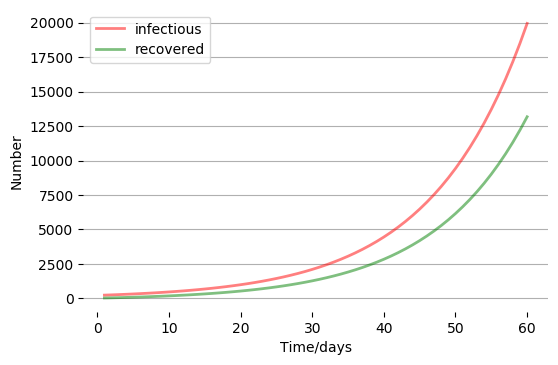

In [7]:
#绘图
fig, ax = plt.subplots(facecolor='w', dpi=100)

for data, color, label_name in zip([solution[:,1], solution[:,2]], ['r', 'g'],['infectious','recovered']):
    ax.plot(t, data, color, alpha = 0.5, lw=2, label=label_name)

ax.set_xlabel('Time/days')
ax.set_ylabel('Number')
ax.legend()
ax.grid(axis='y')
plt.box(False)

In [8]:
#设置疫情的时间跨度为360天
t = np.linspace(1,360,360)

In [9]:
#重新求解
solution = odeint(SIR, y0, t, args=(beta, gamma))

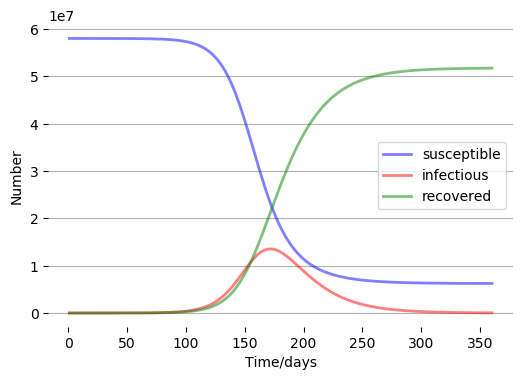

In [10]:
#绘图
fig, ax = plt.subplots(facecolor='w', dpi=100)

for data, color, label_name in zip([solution[:,0] ,solution[:,1], solution[:,2]], ['b','r', 'g'],['susceptible','infectious','recovered']):
    ax.plot(t, data, color, alpha = 0.5, lw=2, label=label_name)

ax.set_xlabel('Time/days')
ax.set_ylabel('Number')
ax.legend()
ax.grid(axis='y')
plt.box(False)

In [11]:
#导入数据
data = pd.read_csv('alltime_province_2020_04_04.csv')
#选择数据中关于湖北省的数据
hubei = data[data['name']=='湖北']

infectious_real = hubei['total_confirm']-hubei['total_heal']-hubei['total_dead']
recovered_real = hubei['total_heal']+hubei['total_dead']
susceptible = N-infectious_real-recovered_real

In [12]:
#确定观察的时间周期
T = len(infectious_real)
#设置估计疫情的时间跨度为T天
t = np.linspace(1,T,T)
#估计三种人是数据量
solution = odeint(SIR, y0, t, args=(beta, gamma))

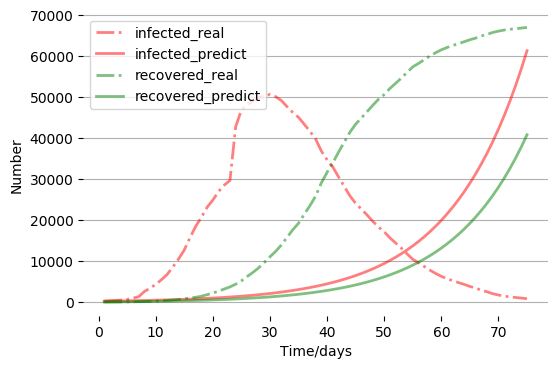

In [13]:
#绘图
fig, ax = plt.subplots(facecolor='w',dpi=100)
#绘制估计的I曲线和真实的I曲线
ax.plot(t, infectious_real, 'r-.', alpha=0.5, lw=2, label='infected_real')
ax.plot(t, solution[:,1], 'r', alpha=0.5, lw=2, label='infected_predict')
#绘制估计的R曲线和真实的R曲线
ax.plot(t, recovered_real, 'g-.', alpha=0.5, lw=2, label='recovered_real')
ax.plot(t, solution[:,2], 'g', alpha=0.5, lw=2, label='recovered_predict')
#设置横纵坐标轴
ax.set_xlabel('Time/days')
ax.set_ylabel('Number')
#添加图例
ax.legend()
ax.grid(axis='y')
plt.box(False)

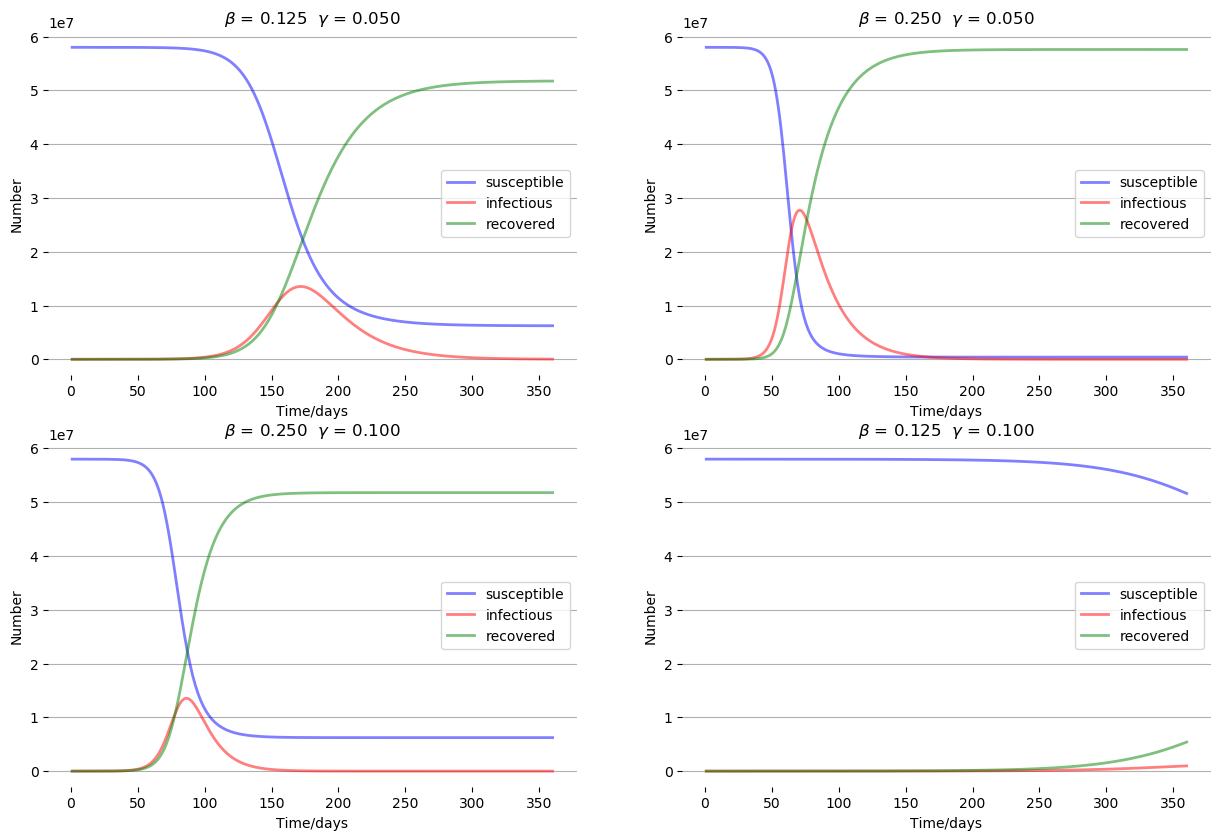

In [14]:
t = np.linspace(1,360,360)
# 设置beta和gamma参数
param_list = [(0.125, 0.05),
             (0.25, 0.05),
             (0.25, 0.1),
             (0.125, 0.1)]
# 预测
solution_list = [odeint(SIR, y0, t, args=item) for item in param_list]
# 绘图
fig = plt.figure(facecolor='w',figsize=(15,10), dpi=100)

for plot_index, solution, params in zip(range(5)[1:], solution_list, param_list):
    
    ax = fig.add_subplot(int('22'+str(plot_index)))
    ax.set_title(r'$\beta$ = %.3f  $\gamma$ = %.3f' % params)
    
    for index, color, label_name in zip(range(3), 
                                        ['b','r','g'],
                                        ['susceptible','infectious','recovered']):
        ax.plot(t, solution[:, index], color, alpha=0.5, lw=2, label=label_name)
    
    ax.set_xlabel('Time/days')
    ax.set_ylabel('Number')
    ax.legend()
    ax.grid(axis='y')
    plt.box(False)

#使用数据拟合参数β和γ

In [15]:
#定义损失函数
def loss(parameters, infectious, recovered ,y0):
    #确定训练的天数
    size = len(infectious)
    #设置时间跨度
    t = np.linspace(1, size, size)
    beta, gamma= parameters
    #计算预测值
    solution = odeint(SIR, y0, t, args=(beta, gamma))
    #计算每日感染者人数的预测值和真实值的均方误差
    l1 = np.mean((solution[:,1]-infectious)**2)
    #计算每日的治愈者人数的预测值和真实值之间的均方误差
    l2 = np.mean((solution[:,2]-recovered)**2)
    #返回SIR模型的损失值
    return l1+l2

#读取数据并划分训练集与验证集

In [16]:
#读取所有国家的疫情数据
data = pd.read_csv('alltime_world_2020_04_04.csv')
#挑选出关于意大利的疫情数据
italy = data[data['name']=='意大利']
italy.head()

,date,total_confirm,total_suspect,total_heal,total_dead,total_severe,today_confirm,today_suspect,today_heal,today_dead,today_severe,today_storeConfirm,name
2754,2020-01-31,2,0,0,0,0,2,0.0,0,0,NaN,NaN,意大利
2755,2020-02-01,2,0,0,0,0,0,0.0,0,0,NaN,NaN,意大利
2756,2020-02-02,2,0,0,0,0,0,0.0,0,0,NaN,NaN,意大利
2757,2020-02-03,2,0,0,0,0,0,0.0,0,0,NaN,NaN,意大利
2758,2020-02-04,2,0,0,0,0,0,0.0,0,0,NaN,NaN,意大利


In [17]:
#构造训练集
#截取1月31日至3月15日之间的意大利疫情数据
italy_train = italy.set_index('date').loc['2020-01-31':'2020-3-15']
#确定训练集每天的感者人数
infectious_train = italy_train['total_confirm']-italy_train['total_heal']-italy_train['total_dead']
#与建立SIR模型时相类似，这里我们也选取每天的康复者和死亡者作为SIR模型的恢复者人数
recovered_train = italy_train['total_heal']+italy_train['total_dead']

In [18]:
#设置总人口数N=60000000
N = 60000000
#确定训练集每天的易感者人数
susceptible_train = N-recovered_train-infectious_train

In [19]:
#生成验证集采用同样的操作
# 截取3月16日至4月3日之间的意大利疫情数据
italy_valid = italy.set_index('date').loc['2020-03-16':'2020-04-03']
# 确定验证集的每天的感染者人数
infectious_valid = italy_valid['total_confirm'] - italy_valid['total_heal'] - italy_valid['total_dead']
# 确定验证集的每天的治愈者人数
recovered_valid = italy_valid['total_heal'] + italy_valid['total_dead']
# 因为我们的损失函数中只包含I(t)和R(t),所以在验证集中，我们不再计算易感者人数


In [20]:
#训练模型

In [21]:
# 模型初始值
I0 = 2
R0 = 0
S0 = N - I0 - R0
y0 = [S0,I0,R0]

# 训练模型
optimal = minimize(loss,[0.0001,0.0001],
                   args=(infectious_train,recovered_train,y0),
                   method='L-BFGS-B',
                   bounds=[(0.00000001, 1), (0.00000001, 1)])


In [22]:
beta,gamma = optimal.x

In [23]:
#下面我们对3月16日至4月3日意大利的疫情进行预测：
#在3月16日时，意大利的感染者人数为23073，治愈者人数为4907。
# 确定初值
I0_valid = 23073
R0_valid = 4907
S0_valid = N - I0_valid- R0_valid
y0_valid = [S0_valid, I0_valid, R0_valid]

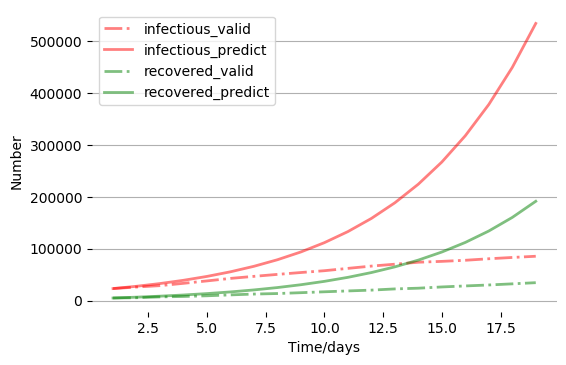

In [24]:
%matplotlib inline
# 确定观察的时间周期
T = len(infectious_valid)
# 设置估计疫情的时间跨度为T天
t = np.linspace(1,T,T)
# 估计三种人数的数量
solution = odeint(SIR, y0_valid, t, args = (beta, gamma))
# 绘图
fig, ax = plt.subplots(facecolor='w', dpi=100)
# 绘制估计的I曲线与真实的I曲线
ax.plot(t, infectious_valid, 'r-.', alpha=0.5, lw=2, label='infectious_valid')
ax.plot(t, solution[:,1], 'r', alpha=0.5, lw=2, label='infectious_predict')
# 绘制估计的R曲线与真实的R曲线
ax.plot(t, recovered_valid, 'g-.', alpha=0.5, lw=2, label='recovered_valid')
ax.plot(t, solution[:,2], 'g', alpha=0.5, lw=2, label='recovered_predict')
# 设置横纵坐标轴
ax.set_xlabel('Time/days')
ax.set_ylabel('Number')
# 添加图例
ax.legend()
ax.grid(axis='y')
plt.box(False)

In [25]:
class SIRModel:
    import numpy as np
    from scipy.integrate import odeint

    def __init__(self, beta, gamma, method):
        self.__beta = beta
        self.__gamma = gamma
        self.__method = method
        self.__optimal = None
        self.__predict_loss = None

    def sir_model(self, y0, t, beta, gamma):
        S, I, R = y0
        dSdt = -beta * S * I / (S + I + R)
        dIdt = beta * S * I / (S + I + R) - gamma * I
        dRdt = gamma * I
        return [dSdt, dIdt, dRdt]

    def loss_function(self, params, infected, recovered, y0):
        size = len(infected)
        t = np.linspace(1, size, size)
        beta, gamma = params
        solution = odeint(self.sir_model, y0, t, args=(beta, gamma))
        l1 = np.mean((solution[:, 1] - infected) ** 2)
        l2 = np.mean((solution[:, 2] - recovered) ** 2)
        return l1 + l2

    def fit(self, y0, infected, recovered):
        self.__optimal = minimize(self.loss_function, [self.__beta, self.__gamma],
                                  args=(infected, recovered, y0),
                                  method=self.__method,
                                  bounds=[(0.00000001, 1), (0.00000001, 1)])

    def predict(self, test_y0, days):
        predict_result = odeint(self.sir_model, test_y0, np.linspace(1, days, days), args=tuple(self.__optimal.x))
        return predict_result

    def get_optimal_params(self):
        return self.__optimal.x

    def get_predict_loss(self):
        return self.__predict_loss


# 模型初始值
def get_init_data(N, I0, R0):
    S0 = N - I0 - R0
    return [S0, I0, R0]

In [26]:
#我们选从3月8日至3月15日的数据作为训练集，训练模型，并对3月16日至4月3日的疫情进行预测。
# 截取3月8日至3月15日之间的意大利疫情数据
italy_train = italy.set_index('date').loc['2020-03-08':'2020-03-15']
# 确定训练集每天的感染者人数
infectious_train = italy_train['total_confirm'] - italy_train['total_heal'] - italy_train['total_dead']
# 与建立SIR模型时相类似，这里我们也选取每天的康复者和死亡者作为SIR模型的恢复者
recovered_train = italy_train['total_heal'] + italy_train['total_dead']

In [27]:
N = 60000000
I0 = 6534
R0 = 988
y0 = get_init_data(N, 8514, 1635)

In [28]:
#建立模型，设定beta gamma初始值，优化方法
model = SIRModel(0.0001, 0.0001, 'L-BFGS-B')

#训练模型， 输入参数： 初始值，训练集
model.fit(y0, infectious_train, recovered_train)

#输出估计最优参数
best_params = model.get_optimal_params()

In [29]:
best_params

array([0.14188852, 0.02185075])

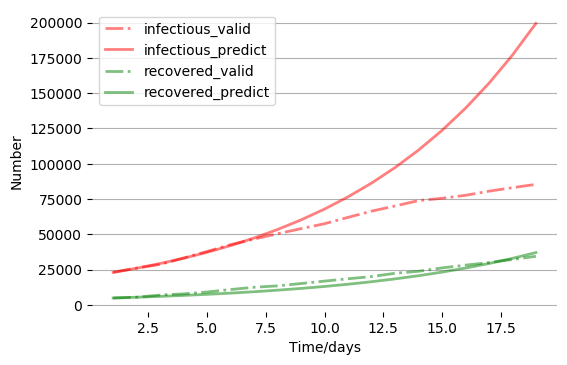

In [30]:
#用新估计出的参数值来预测3月16日至4月3日的易感者、感染者和恢复者的数量：
# 3月16日疫情初值
I0_valid = 23073
R0_valid = 4907
y0_valid = get_init_data(N, I0_valid, R0_valid)
# 预测
predict_result = model.predict(y0_valid,19)

t = np.linspace(1,T,T)
# 绘图
fig, ax = plt.subplots(facecolor='w', dpi=100)
# 绘制估计的I曲线与真实的I曲线
ax.plot(t, infectious_valid, 'r-.', alpha=0.5, lw=2, label='infectious_valid')
ax.plot(t, predict_result[:,1], 'r', alpha=0.5, lw=2, label='infectious_predict')
# 绘制估计的R曲线与真实的R曲线
ax.plot(t, recovered_valid, 'g-.', alpha=0.5, lw=2, label='recovered_valid')
ax.plot(t, predict_result[:,2], 'g', alpha=0.5, lw=2, label='recovered_predict')
# 设置横纵坐标轴
ax.set_xlabel('Time/days')
ax.set_ylabel('Number')
# 添加图例
ax.legend()
ax.grid(axis='y')
plt.box(False)

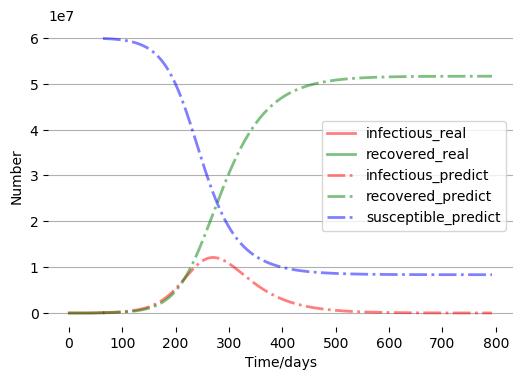

In [31]:
#疫情发展趋势预测
# 截取3月31日至4月3日之间的意大利疫情数据
italy_train = italy.set_index('date').loc['2020-03-31':'2020-04-03']
# 确定训练集每天的感染者人数
infectious_train = italy_train['total_confirm'] - italy_train['total_heal'] - italy_train['total_dead']
# 与建立SIR模型时相类似，这里我们也选取每天的康复者和死亡者作为SIR模型的恢复者
recovered_train = italy_train['total_heal'] + italy_train['total_dead']

N = 60000000
I0 = 77635
R0 = 28157
y0 = get_init_data(N, I0, R0)

# 建立模型，设定beta gamma初始值，优化方法
new_model = SIRModel(0.0001, 0.0001, 'L-BFGS-B')

# 训练模型，输入参数：初始值，训练集
new_model.fit(y0, infectious_train,recovered_train)

# 输出估计最优参数
best_params = new_model.get_optimal_params()

#训练完成
#########################
#最后我们预测从4月4日至未来两年的疫情
N = 60000000
I0 = 85388
R0 = 34439
y0_test = get_init_data(N, I0, R0)

# 进行预测
predict_result = new_model.predict(y0_test,730)
infectious_real = italy['total_confirm'] - italy['total_heal'] - italy['total_dead']
recovered_real = italy['total_heal'] + italy['total_dead']
t = np.linspace(1,len(infectious_real),len(infectious_real))
tpredict = np.linspace(64,793,730)

fig = plt.figure(facecolor='w',dpi=100)
ax = fig.add_subplot(111)
# 绘制真实的I曲线与真实的R曲线
ax.plot(t, infectious_real, 'r', alpha=0.5, lw=2, label='infectious_real')
ax.plot(t, recovered_real, 'g', alpha=0.5, lw=2, label='recovered_real')
# 绘制预测的I曲线、R曲线与S曲线
ax.plot(tpredict, predict_result[:,1], 'r-.', alpha=0.5, lw=2, label='infectious_predict')
ax.plot(tpredict, predict_result[:,2], 'g-.', alpha=0.5, lw=2, label='recovered_predict')
ax.plot(tpredict, predict_result[:,0], 'b-.', alpha=0.5, lw=2, label='susceptible_predict')


# 设置横纵坐标轴
ax.set_xlabel('Time/days')
ax.set_ylabel('Number')
# 添加图例
legend = ax.legend()
ax.grid(axis='y')
plt.box(False)